# 5.10 多様体学習　MDS（多次元尺度構成法）

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [2]:
#HELLOという２次元データの作成
def make_hello(N=1000, rseed=42):
    # HELLOをプロとしてPNGとして保存する
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # PNGをオープンしてそこからランダムに点を描画する
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

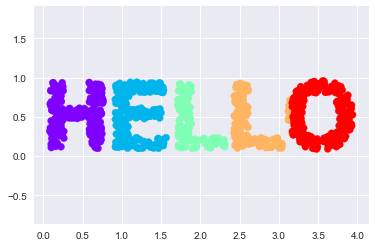

In [3]:
#上で定義した関数を呼び出して、結果を可視化する
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');
plt.show()

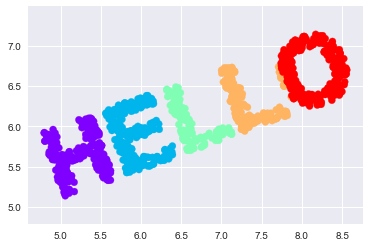

In [4]:
#HELLOを回転してもHELLOに見える。回転行列を使用する
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
#20度回転してみた    
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');
plt.show()

#xとyの値が必ずしもデータの関係にとって本質的でないということがわかる
#このケースでは各ポイント間の距離が関係している

In [5]:
#Nポイントの場合N*Nの行列を作成して各ポイント間の距離を行列で表す。
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

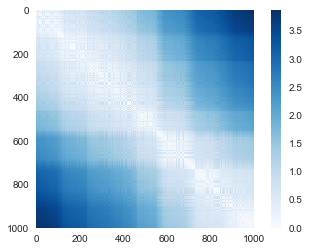

In [6]:
#上記を可視化する
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();
plt.show()

In [7]:
#回転させたデータ(X2)の距離行列も同じであることを確認
D2 = pairwise_distances(X2)
np.allclose(D, D2) #２つの行列の成分が同じか調べることができる

True

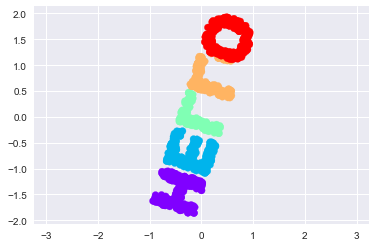

In [8]:
#行列を可視化した結果は全然直感的でなく、HELLOを読み取ることもできない。
#ここでMDS(多次元尺度構成法)を用いて距離行列から元のデータを復元する。
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D) #行列DをMDS(model)を用いて変換する。
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');
plt.show()

In [9]:
#距離行列から３次元に投影することができる。
#回転行列を３次元に一般化した関数を使用する
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

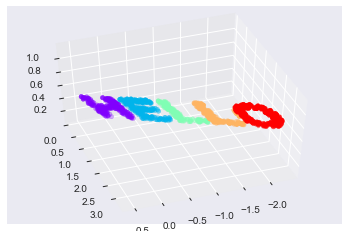

In [10]:
#可視化する。
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)
plt.show()

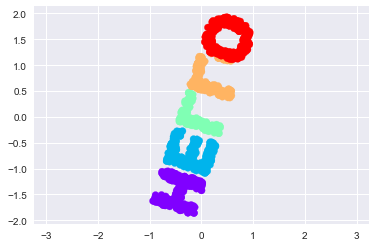

In [11]:
#上の３次元データをMDSに落とし込んで計算すると２次元の元のデータが復元される。
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');
plt.show()

## 5.10.4 MDSがうまくいかない場合

ここまでは回転、平行移動、拡大など線形な埋め込みについて考えてきたが、非線形の場合はMDSがうまく動かない。

In [12]:
#３次元空間でSの形に曲げて配置する
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

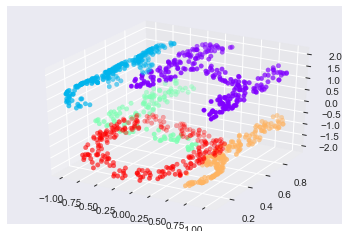

In [13]:
#可視化
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],**colorize);
plt.show()

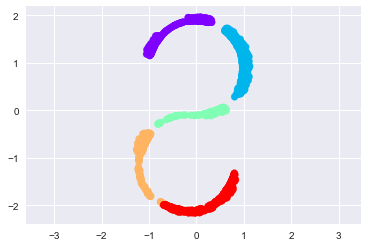

In [14]:
#Sになる
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');
plt.show()

https://jakevdp.github.io/PythonDataScienceHandbook/06.00-figure-code.html#LLE-vs-MDS-Linkages

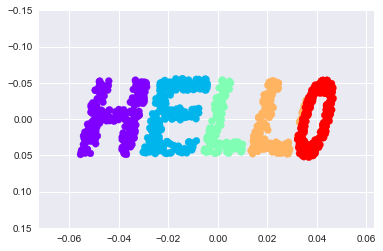

In [15]:
#LLE(局所的線形埋め込み)を用いて近傍点間の距離のみを保存する。２点間の線の長さをほぼ同じに保ちながらデータを展開することができる。
#以下は改良LLEと呼ばれるLLEを改良したものを用いて、埋め込まれている２次元多様体を復元する。
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);
plt.show()

## 5.10.6 多様体学習に対する考察

https://jakevdp.github.io/PythonDataScienceHandbook/05.10-manifold-learning.html#Some-Thoughts-on-Manifold-Methods

## 5.10.7 事例：顔画像へのIsomap適用

In [18]:
#opencv(画像処理のライブラリ)をインストールする。
#多様体学習は高次元データのポイント間の関係を理解するのに使用される。高次元データの一般的な事例の一つが画像。1000ピクセルの画像は1000次元の点の集まりと捉えることができる。
#5.7と5.9で使用したlabeled faces in the wild のデータセットを用いる
import cv2
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
#30は最低30マイ以上画像がある人の顔画像を取ってくるということ
faces.data.shape

(2370, 2914)

2914ピクセルの画像が2370個あるってこと 

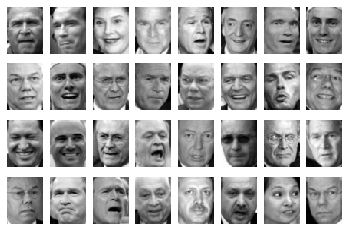

In [22]:
#読み込んだデータをいくつか可視化
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
#subplots(4行,8列,何番目か)

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')
#enumerate():インデックスと要素だけを取得する

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


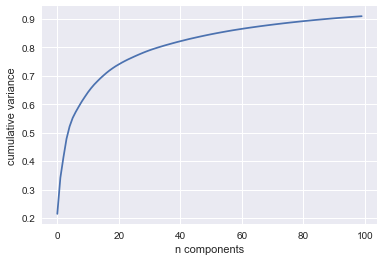

In [23]:
#PCA(主成分分析)を計算して因子寄与率を調べる
from sklearn.decomposition import RandomizedPCA
model = RandomizedPCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');
plt.show()

分散の90%を維持するためには100以上の成分が必要とわかる。この場合、非線形多様体埋め込みが役に立つ。

In [24]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

2370個の2次元投影

In [25]:
#投影された点に画像のサムネイルを出力する関数を定義
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

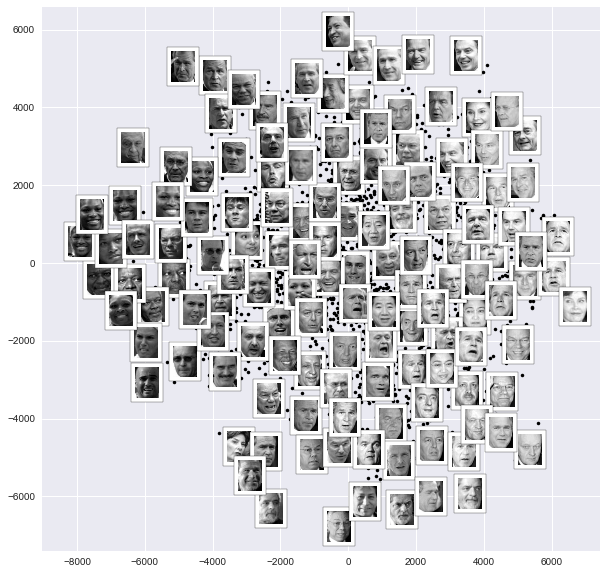

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])